# Predict song genre based on audio features (Spotify dataset)

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, mean_squared_error, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb 
import bentoml

# Load (small) dataset with selected columns

In [2]:
# Load and display head
df = pd.read_csv("./data/spotify_songs_small.csv")
print(f"Columns:\n{df.columns.values}")
df.head()

Columns:
['popularity' 'danceability' 'energy' 'key' 'loudness' 'mode'
 'speechiness' 'acousticness' 'instrumentalness' 'liveness' 'valence'
 'tempo' 'category' 'time_signature' 'duration_ms']


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,category,time_signature,duration_ms
0,4,0.659,0.166,2,-14.523,0,0.0753,0.8770,0.050200,0.1010,0.345,49.320,blues,4,186973
1,23,0.701,0.205,3,-13.458,1,0.0582,0.9590,0.003590,0.0716,0.839,101.734,blues,4,145853
2,31,0.498,0.824,5,-7.832,0,0.1320,0.0641,0.000112,0.1800,0.549,157.040,blues,4,251627
3,40,0.584,0.370,8,-7.313,1,0.0348,0.8610,0.000011,0.1080,0.073,136.012,blues,4,296082
4,36,0.467,0.122,2,-22.241,1,0.0366,0.9540,0.902000,0.1320,0.411,111.256,blues,4,178333


In [3]:
# Visualize basic info
df.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms
count,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,26752.000000,2.675200e+04
mean,46.603544,0.551091,0.698948,5.299604,-7.231568,0.623131,0.085210,0.186927,0.110631,0.198308,0.493760,123.791402,3.936379,2.316677e+05
std,18.890180,0.166505,0.210743,3.566726,3.312386,0.484611,0.087807,0.265412,0.246161,0.156232,0.233485,29.365056,0.334642,7.955645e+04
min,0.000000,0.000000,0.000020,0.000000,-34.825000,0.000000,0.000000,0.000000,0.000000,0.011900,0.000000,0.000000,0.000000,1.379300e+04
25%,34.000000,0.439000,0.558000,2.000000,-8.802000,0.000000,0.035800,0.002370,0.000000,0.097300,0.313000,100.017000,4.000000,1.862860e+05
50%,46.000000,0.550000,0.730000,5.000000,-6.599000,1.000000,0.050600,0.044450,0.000262,0.134000,0.490000,122.005000,4.000000,2.176090e+05
75%,60.000000,0.667000,0.877000,9.000000,-4.955000,1.000000,0.091300,0.285000,0.033400,0.267000,0.673000,143.373000,4.000000,2.582270e+05
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.960000,0.996000,0.996000,0.992000,0.986000,249.438000,5.000000,1.561133e+06


In [4]:
# Check for missing values
df.isna().sum()

popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
category            0
time_signature      0
duration_ms         0
dtype: int64

In [5]:
# Get numeric and categorical columns
numeric_columns = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index.values
categorical_columns = df.dtypes[df.dtypes == 'object'].index.values
print(f"Numeric columns: {numeric_columns}")
print(f"Categorical columns: {categorical_columns}")

Numeric columns: ['popularity' 'danceability' 'energy' 'key' 'loudness' 'mode'
 'speechiness' 'acousticness' 'instrumentalness' 'liveness' 'valence'
 'tempo' 'time_signature' 'duration_ms']
Categorical columns: ['category']


# Train, validation, test split

In [6]:
# Extract target column
target_column = 'category'
#y = df.pop(target_column)
print(df[target_column].value_counts())
remapping_to_numbers = {"rock" : 0, 
                        "indie" : 1, 
                        "pop": 2, 
                        "metal" : 3, 
                        "hiphop": 4,
                        "alternative": 5,
                        "blues": 6}

remapping_to_numbers = {"rock" : 1, 
                        "indie" : 0, 
                        "pop": 0, 
                        "metal" : 1, 
                        "hiphop": 0,
                        "alternative": 1,
                        "blues": 0}

df[target_column]=df[target_column].replace(remapping_to_numbers)
df[target_column].value_counts()

rock           8747
indie          4338
pop            3831
metal          3045
hiphop         2581
alternative    2160
blues          2050
Name: category, dtype: int64


1    13952
0    12800
Name: category, dtype: int64

In [7]:
# Splitting the dataset 60%-20%-20% (train-val-test)
#df_train_val, df_test, y_train_val, y_test = train_test_split(df, y, test_size = 0.2, random_state=1)
#df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.25, random_state=1)

df_train_val, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size = 0.25, random_state=1)

# Initial feature selection (based on feature distribution)

In [8]:
# Select features
selected_columns = ['danceability',
                    'energy',
                    target_column]

df_train = df_train[selected_columns]
df_val = df_val[selected_columns]
df_test = df_test[selected_columns]

# Extract target value and features

In [9]:
y_train = df_train.pop(target_column).values
X_train = df_train.values

In [10]:
y_val = df_val.pop(target_column).values
X_val = df_val.values

In [11]:
y_test = df_test.pop(target_column).values
X_test = df_test.values

# Train final model

In [12]:
# Select XGB Classifier model based on the previous experiments
xgb_params = {
                'eta': 0.1, 
                'max_depth': 3,
                'min_child_weight': 10,
                'objective': 'reg:logistic',
                'eval_metric': 'auc',

                'nthread': 8,
                'seed': 1,
                'verbosity': 1,
            }


# Retrain on training and validation sets
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=None)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=None)
watchlist = [(dtrain_full,'train'), (dtest,'eval')]
#watchlist = None
xgb_classifier = xgb.train(xgb_params, dtrain_full, evals=watchlist, num_boost_round=50)

[0]	train-auc:0.76878	eval-auc:0.76542
[1]	train-auc:0.77010	eval-auc:0.76721
[2]	train-auc:0.77479	eval-auc:0.77063
[3]	train-auc:0.77605	eval-auc:0.77127
[4]	train-auc:0.77790	eval-auc:0.77304
[5]	train-auc:0.77916	eval-auc:0.77471
[6]	train-auc:0.77979	eval-auc:0.77484
[7]	train-auc:0.77985	eval-auc:0.77550
[8]	train-auc:0.77975	eval-auc:0.77507
[9]	train-auc:0.78105	eval-auc:0.77623
[10]	train-auc:0.78158	eval-auc:0.77720
[11]	train-auc:0.78192	eval-auc:0.77701
[12]	train-auc:0.78209	eval-auc:0.77727
[13]	train-auc:0.78226	eval-auc:0.77719
[14]	train-auc:0.78246	eval-auc:0.77720
[15]	train-auc:0.78258	eval-auc:0.77712
[16]	train-auc:0.78262	eval-auc:0.77728
[17]	train-auc:0.78293	eval-auc:0.77759
[18]	train-auc:0.78306	eval-auc:0.77760
[19]	train-auc:0.78310	eval-auc:0.77754
[20]	train-auc:0.78314	eval-auc:0.77776
[21]	train-auc:0.78333	eval-auc:0.77794
[22]	train-auc:0.78342	eval-auc:0.77806
[23]	train-auc:0.78348	eval-auc:0.77801
[24]	train-auc:0.78358	eval-auc:0.77814
[25]	train

Training roc_auc_score: 0.7854049927041864
Test roc_auc_score: 0.77904732822549


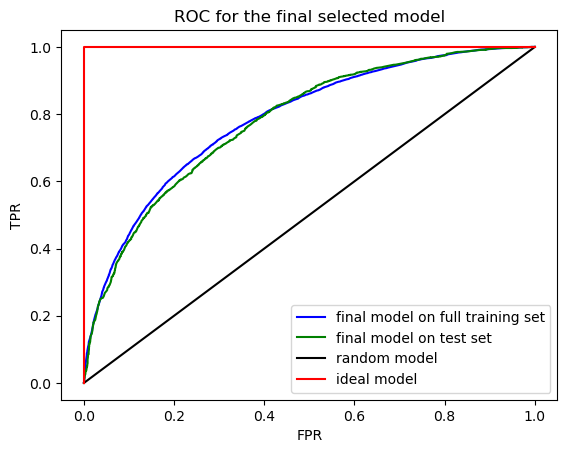

In [13]:
# Evaluation on the training set
y_pred_train_full = xgb_classifier.predict(dtrain_full)
fpr_train_full, tpr_train_full, thresholds_test = roc_curve(y_train_full, y_pred_train_full)
print(f"Training roc_auc_score: {roc_auc_score(y_train_full, y_pred_train_full)}")

# Evaluation on  the test set
y_pred_test = xgb_classifier.predict(dtest)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
print(f"Test roc_auc_score: {roc_auc_score(y_test, y_pred_test)}")

# Plotting ROCs
plt.plot(fpr_train_full, tpr_train_full, color='blue', label="final model on full training set")
plt.plot(fpr_test, tpr_test, color='green', label="final model on test set")

plt.plot([0, 1], [0, 1], color='black', label="random model")
plt.plot([0,0,1], [0,1,1], color='red', label="ideal model")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC for the final selected model")
plt.legend()
plt.show()

# Export model using BentoML

In [14]:
# Export model to BentoML
model = xgb_classifier
bentoml.xgboost.save_model('rock_alt_metal_song_genre_model', model, signatures={"predict": {"batchable": True}})

Model(tag="rock_alt_metal_song_genre_model:brwfj2c6c2ukvjgr", path="/Users/dg/bentoml/models/rock_alt_metal_song_genre_model/brwfj2c6c2ukvjgr/")

In [15]:
# Check the export by importing the model
booster = bentoml.xgboost.load_model("rock_alt_metal_song_genre_model:latest")

print(f"Predicted value: {booster.predict(xgb.DMatrix([df_test.iloc[10].values]))}, expected value: {y_test[10]}")
print(f"Predicted value: {booster.predict(xgb.DMatrix([df_test.iloc[2].values]))}, expected value: {y_test[2]}")

Predicted value: [0.4630461], expected value: 0
Predicted value: [0.3117444], expected value: 0


In [16]:
print(f"Predicted value: {booster.predict(xgb.DMatrix([df_test.iloc[2].values]))}, expected value: {y_test[2]}")

Predicted value: [0.3117444], expected value: 0


# Test the service

In [17]:
!curl -X 'POST' 'http://0.0.0.0:3000/classify_song' -H 'accept: application/json' -H 'Content-Type: application/json' -d '{"danceability":0.5, "energy":0.5}'

curl: (7) Failed to connect to 0.0.0.0 port 3000: Connection refused


In [18]:
!curl -m 300 -X 'POST' 'https://songgenre2.azurewebsites.net/classify_song' -H 'accept: application/json' -H 'Content-Type: application/json' -d '{"danceability":0.5, "energy":0.5}'

{"res":"blues/indie/hiphop","proba":[0.4532536268234253]}